In [ ]:
#imports
!pip install dimod
!pip install dwave-neal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import random
import seaborn as sns
import dimod
from neal import SimulatedAnnealingSampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 54.1 MB/s eta 0:00:00


In [ ]:
#parameters from v2
num_agents = 100
total_rounds = 1000
compromise_rate = 5e-5
penalty = 0.05
reward = 0.02
alpha = 0.1
use_countermeasures = True
countermeasure_success_threshold = 5
countermeasure_restore_amount = 0.01
rng = np.random.default_rng(seed=42)

#attack parameters from v3
gps_spoof_severity = 0.1
sensor_noise_level = 0.05
adversarial_penalty = 0.1

In [ ]:
#Hospital layout from v3
G = nx.Graph()

floors = 3
x_rooms = 4
y_rooms = 3
room_spacing_x = 24
room_spacing_y = 26
floor_spacing_z = 15

room_ids = {}
for z in range(floors):
    for y in range(y_rooms):
        for x in range(x_rooms):
            room_num = z * 100 + 101 + (y * x_rooms + x)
            node_id = str(room_num)
            room_type = random.choice(["ward", "ICU", "OR", "storage", "lobby"])
            urgency_value = {"ICU": 0.9, "OR": 0.7, "ward": 0.5}.get(room_type, 0.2)

            G.add_node(node_id,
                       type="room",
                       x=x * room_spacing_x,
                       y=y * room_spacing_y,
                       z=z * floor_spacing_z,
                       structural_integrity=1.0,
                       urgency=urgency_value,
                       occupants=random.randint(0, 3),
                       room_type=room_type)

            room_ids[(x, y, z)] = node_id

#adding connections
for z in range(floors):
    for y in range(y_rooms):
        for x in range(x_rooms - 1):
            n1 = room_ids[(x, y, z)]
            n2 = room_ids[(x + 1, y, z)]
            G.add_edge(n1, n2, edge_type="hallway", status="open", distance=room_spacing_x)

outer_cols = [0, x_rooms - 1]
for z in range(floors):
    for x in outer_cols:
        for y in range(y_rooms - 1):
            n1 = room_ids[(x, y, z)]
            n2 = room_ids[(x, y + 1, z)]
            G.add_edge(n1, n2, edge_type="hallway", status="open", distance=room_spacing_y)

for z in range(floors - 1):
    G.add_edge(room_ids[(0, 0, z)], room_ids[(0, 0, z + 1)], edge_type="elevator", status="open", distance=floor_spacing_z)
    G.add_edge(room_ids[(3, 2, z)], room_ids[(3, 2, z + 1)], edge_type="stair", status="open", distance=floor_spacing_z)

#main exits
room_102 = room_ids[(1, 0, 0)]
room_103 = room_ids[(2, 0, 0)]
exit_x = (G.nodes[room_102]["x"] + G.nodes[room_103]["x"]) / 2
exit_y = (G.nodes[room_102]["y"] + G.nodes[room_103]["y"]) / 2
exit_z = G.nodes[room_102]["z"]
exit_node_id = "EXIT"
G.add_node(exit_node_id, type="exit", x=exit_x, y=exit_y, z=exit_z)
G.add_edge(room_102, exit_node_id, edge_type="exit", status="open", distance=10)
G.add_edge(room_103, exit_node_id, edge_type="exit", status="open", distance=10)

print("Hospital layout graph created")

Hospital layout graph created


In [ ]:
#extract room data to dataframe

room_data = []
for node, data in G.nodes(data=True):
    if data.get("type") in ["room", "exit"]:
        room_data.append({
            'room_id': node,
            'x': data.get('x', 0),
            'y': data.get('y', 0),
            'z': data.get('z', 0),
            'room_type': data.get('room_type', 'unknown'),
            'structural_integrity': data.get('structural_integrity', 1.0),
            'urgency': data.get('urgency', 0.0),
            'occupants': data.get('occupants', 0)
        })

hospital_layout = pd.DataFrame(room_data)
print("\n Hospital layout DataFrame:")
display(hospital_layout)

tasks = hospital_layout['room_id'].tolist()
num_tasks = len(tasks)
print(f"\n Tasks list created with {num_tasks} rooms.")


 Hospital layout DataFrame:


,room_id,x,y,z,room_type,structural_integrity,urgency,occupants
0,101,0.0,0.0,0,lobby,1.0,0.2,3
1,102,24.0,0.0,0,ward,1.0,0.5,0
2,103,48.0,0.0,0,ward,1.0,0.5,1
3,104,72.0,0.0,0,storage,1.0,0.2,3
4,105,0.0,26.0,0,storage,1.0,0.2,2
5,106,24.0,26.0,0,lobby,1.0,0.2,0
6,107,48.0,26.0,0,OR,1.0,0.7,2
7,108,72.0,26.0,0,ward,1.0,0.5,3
8,109,0.0,52.0,0,lobby,1.0,0.2,2
9,110,24.0,52.0,0,ward,1.0,0.5,2



 Tasks list created with 37 rooms.


In [ ]:
#robot initalization from v2+v3

robots = {}
for i in range(num_agents):
    initial_trust = round(random.uniform(0.5, 0.95), 2)
    assigned_room = random.choice(tasks)
    robots[i] = {
        'trust': initial_trust,
        'trust_history': [initial_trust],
        'compromised': False,
        'success_count': 0,
        'fail_count': 0,
        'assigned_room': assigned_room
    }
print(f"Initialized {num_agents} robots with assigned rooms")

Initialized 100 robots with assigned rooms


In [ ]:
#attack functions from v3

def gps_spoofing_attack(robots, gps_spoofed_rooms):
    for r in robots.values():
        if r['assigned_room'] in gps_spoofed_rooms:
            r['trust'] = max(0.05, r['trust'] - gps_spoof_severity)

def adversarial_poisoning(robots, target_robot_ids):
    for tid in target_robot_ids:
        if tid in robots:
            robots[tid]['trust'] = max(0.05, robots[tid]['trust'] - adversarial_penalty)

def apply_countermeasures(robots):
    for r in robots.values():
        if r['success_count'] > countermeasure_success_threshold and r['trust'] < 0.9:
            r['trust'] = min(0.95, r['trust'] + countermeasure_restore_amount)

In [ ]:
#qubo using neal

def run_qubo_solver(trust_matrix):
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #maximize trust-based assignments
    for agent in range(num_agents):
        for task in range(num_tasks):
            var = f'A{agent}_T{task}'
            bqm.add_variable(var, -trust_matrix[agent][task])

    #one agent per task constraint
    for task in range(num_tasks):
        for i in range(num_agents):
            for j in range(i+1, num_agents):
                bqm.add_interaction(f'A{i}_T{task}', f'A{j}_T{task}', 2)

    #one task per agent constraint
    for agent in range(num_agents):
        for i in range(num_tasks):
            for j in range(i+1, num_tasks):
                bqm.add_interaction(f'A{agent}_T{i}', f'A{agent}_T{j}', 2)

    #solving with neal
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=10)
    return sampleset.first.sample

In [ ]:
#tracks compromised robots, successes, and failures over time
compromised_counts = []
success_counts = []
fail_counts = []

In [ ]:
for round_num in tqdm(range(total_rounds)):

    round_compromised = 0
    round_success = 0
    round_fail = 0

    for robot in robots.values():

        robot['compromised'] = robot['compromised'] | (rng.random() < compromise_rate) # compromise persists

        if robot['compromised']:
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.05, (1-alpha)*robot['trust'] + alpha*(robot['trust']-penalty))  # exponential decay
        else:
            if rng.random() < robot['trust']:
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(0.95, (1-alpha)*robot['trust'] + alpha*(robot['trust']+reward)) # exponential decay
            else:
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.05, (1-alpha)*robot['trust'] + alpha*(robot['trust']-penalty)) # exponential decay

          # # Defense mechanism     # Seems to work with or without.  Might try with most recent 10 tasks
          # if use_countermeasures:
          #     if robot['success_count'] > 5 and robot['trust'] < 0.9:
          #         robot['trust'] += 0.01

        robot['trust_history'].append(robot['trust'])

    #attacks reduce trust from v3
    #GPS spoofing
    gps_spoofed_rooms = random.sample(tasks, k=2)
    gps_spoofing_attack(robots, gps_spoofed_rooms)

    #sensor noise
    noisy_robots = random.sample(list(robots.keys()), k=int(0.3 * num_agents))
    for robot_id in noisy_robots:
        robots[robot_id]['trust'] = max(0.05, min(0.95, robots[robot_id]['trust'] + np.random.normal(0, sensor_noise_level)))

    #adversarial poisoning
    adversarial_targets = random.sample(list(robots.keys()), k=3)
    adversarial_poisoning(robots, adversarial_targets)

    #countermeasures from v2
    if use_countermeasures:
        apply_countermeasures(robots)

    #record round
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

    #create assisgnment matrix from v3
    trust_matrix = np.array([
        [r['trust'] for t in range(num_tasks)]
        for r in robots.values()
    ])
    assignment = run_qubo_solver(trust_matrix)

print(f"\n Simulation of {total_rounds} rounds complete")


  0%|          | 0/1000 [00:00<?, ?it/s]


 Simulation of 1000 rounds complete


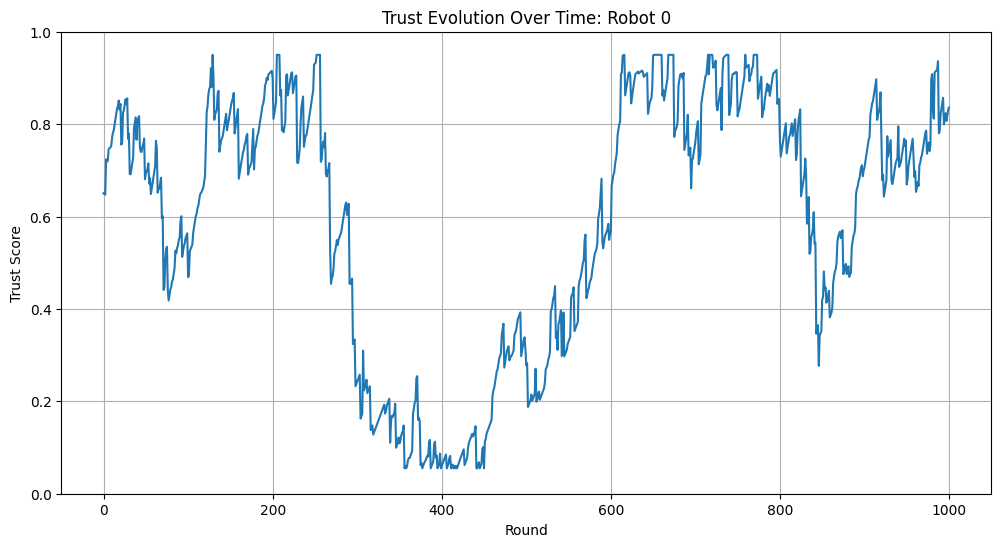

In [ ]:
#trust score history

example_robot_id = 0
plt.figure(figsize=(12,6))
plt.plot(robots[example_robot_id]['trust_history'])
plt.title(f"Trust Evolution Over Time: Robot {example_robot_id}")
plt.xlabel("Round")
plt.ylabel("Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()


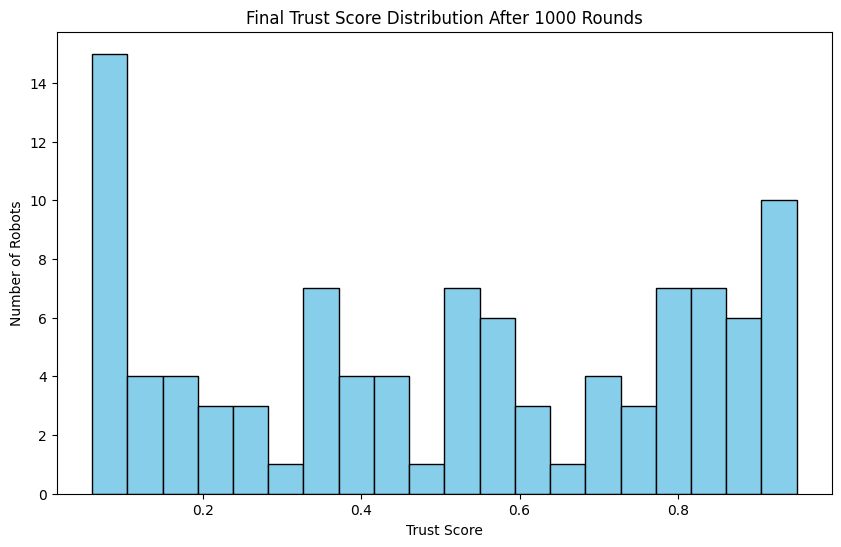

In [ ]:
#shows how many robots ended up with high or low trust

final_trust_scores = [robot['trust'] for robot in robots.values()]
plt.figure(figsize=(10,6))
plt.hist(final_trust_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Final Trust Score Distribution After 1000 Rounds")
plt.xlabel("Trust Score")
plt.ylabel("Number of Robots")
plt.show()

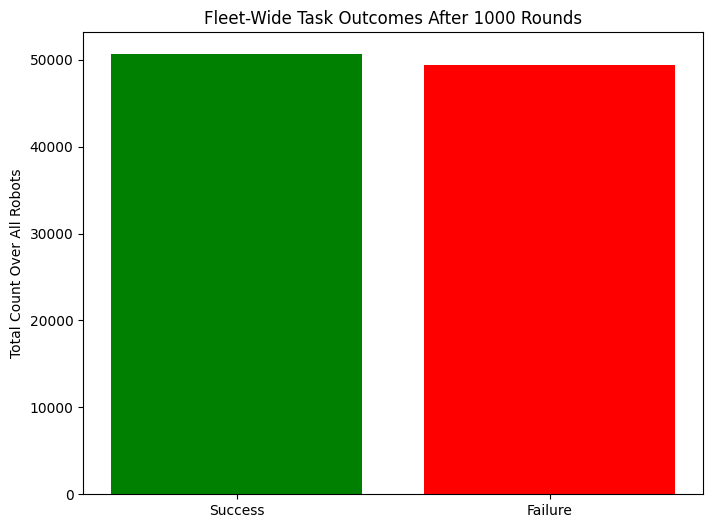

Total Successes: 50618
Total Failures: 49382


In [ ]:
#total number of successful and failed tasks

total_success = sum(r['success_count'] for r in robots.values())
total_fail = sum(r['fail_count'] for r in robots.values())
plt.figure(figsize=(8,6))
plt.bar(['Success', 'Failure'], [total_success, total_fail], color=['green', 'red'])
plt.title("Fleet-Wide Task Outcomes After 1000 Rounds")
plt.ylabel("Total Count Over All Robots")
plt.show()

print(f"Total Successes: {total_success}")
print(f"Total Failures: {total_fail}")

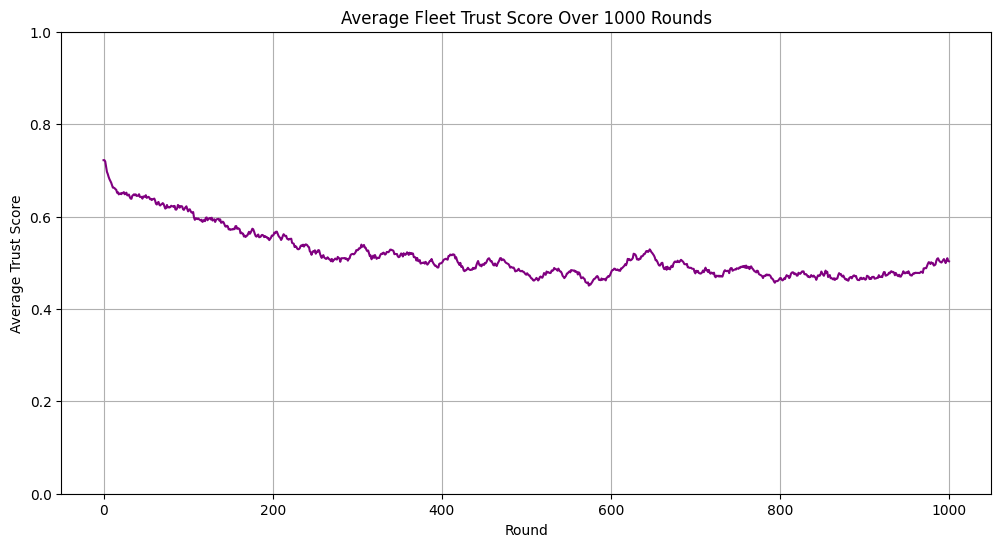

In [ ]:
#average trust across all robots at each round

rounds = len(next(iter(robots.values()))['trust_history'])
average_trust_per_round = [
    np.mean([r['trust_history'][round_idx] for r in robots.values()])
    for round_idx in range(rounds)
]
plt.figure(figsize=(12,6))
plt.plot(range(rounds), average_trust_per_round, color='purple')
plt.title("Average Fleet Trust Score Over 1000 Rounds")
plt.xlabel("Round")
plt.ylabel("Average Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

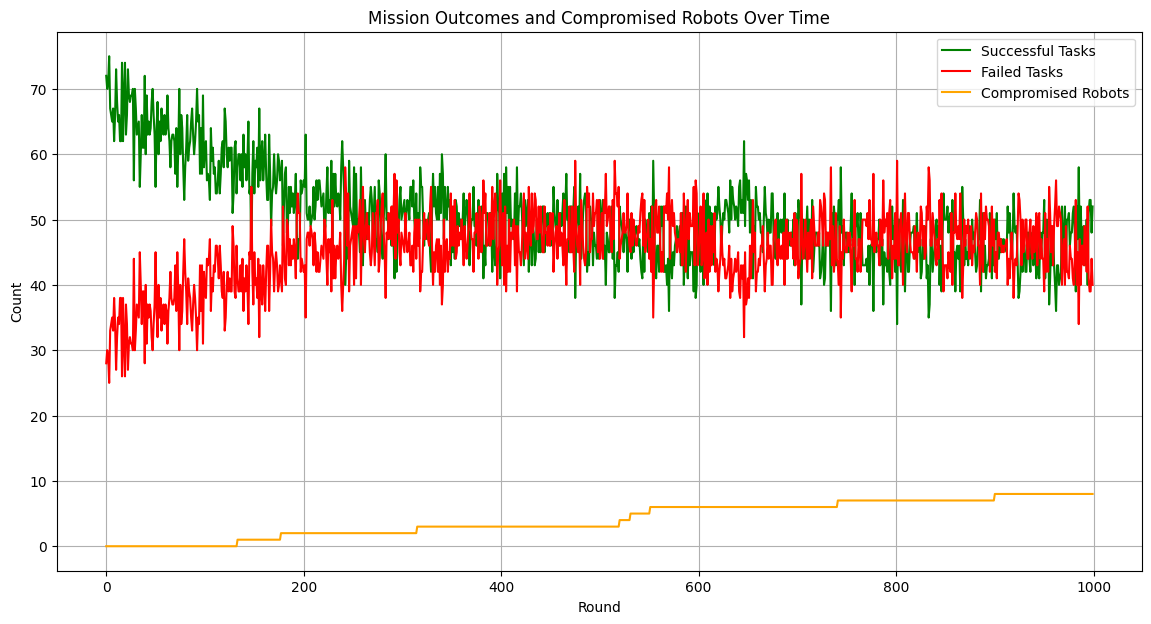

In [ ]:
#compromised robots, successes, and failures

plt.figure(figsize=(14,7))
plt.plot(range(total_rounds), success_counts, label='Successful Tasks', color='green')
plt.plot(range(total_rounds), fail_counts, label='Failed Tasks', color='red')
plt.plot(range(total_rounds), compromised_counts, label='Compromised Robots', color='orange')
plt.title("Mission Outcomes and Compromised Robots Over Time")
plt.xlabel("Round")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

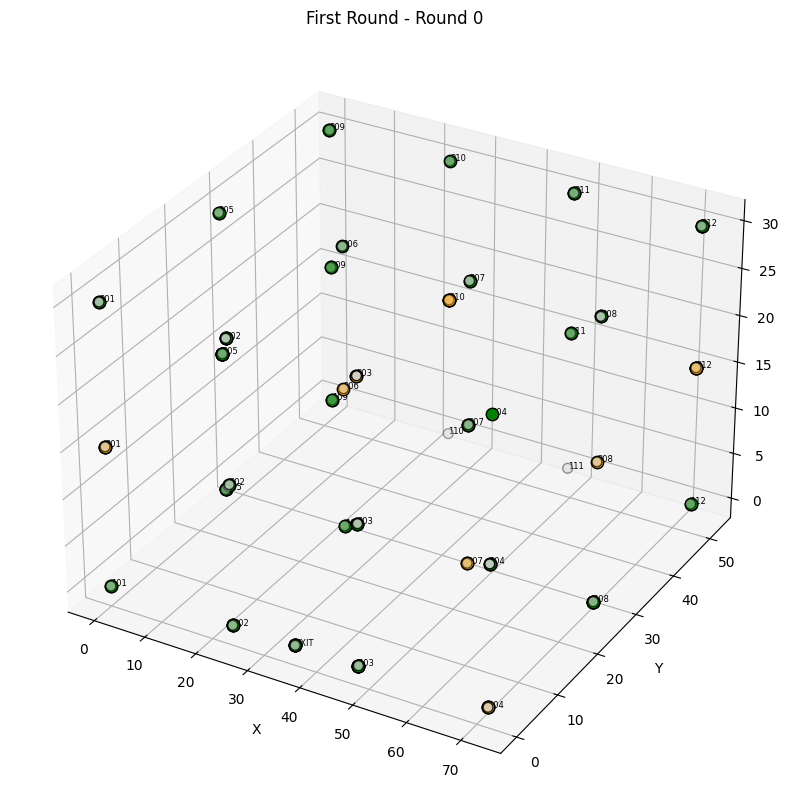

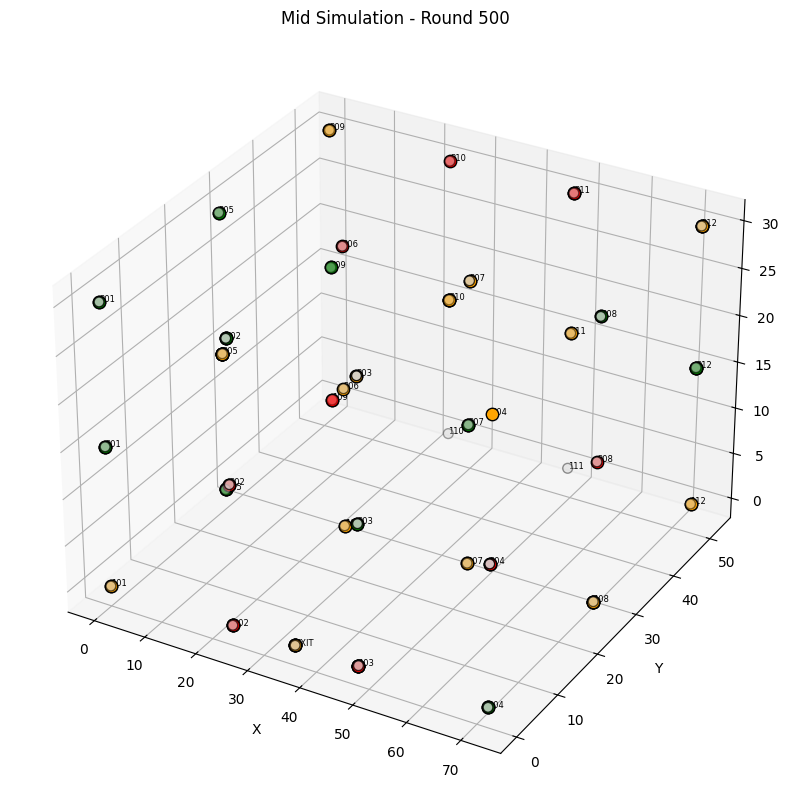

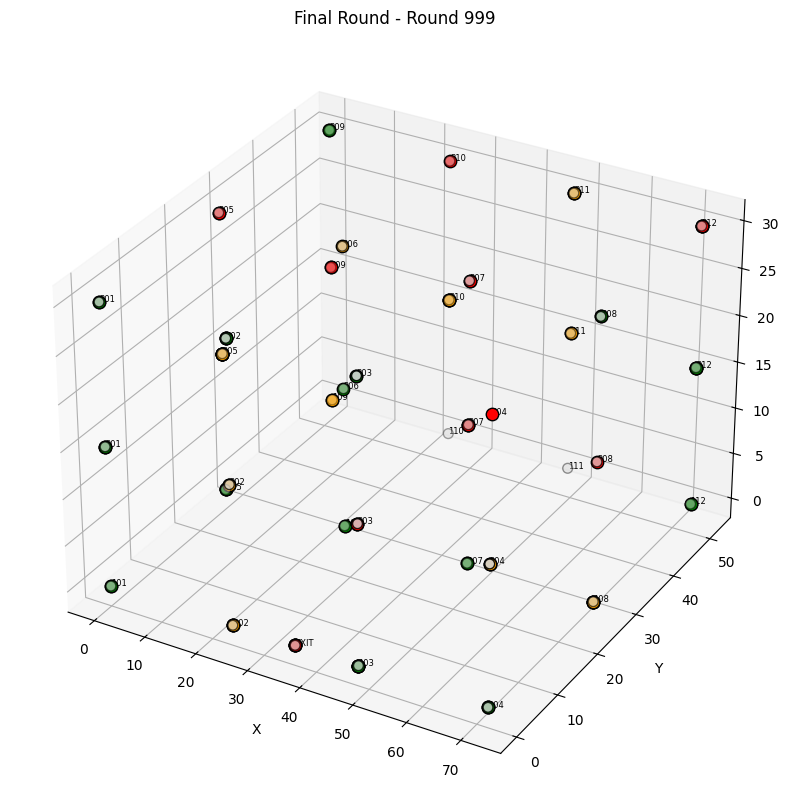

In [ ]:
selected_rounds = [0, total_rounds // 2, total_rounds - 1]
titles = ['First Round', 'Mid Simulation', 'Final Round']

for idx, round_num in enumerate(selected_rounds):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    #plotting rooms
    ax.scatter(
        hospital_layout['x'], hospital_layout['y'], hospital_layout['z'],
        c='lightgray', s=50, edgecolor='k'
    )

    #labeling rooms
    for i, row in hospital_layout.iterrows():
        ax.text(row['x'], row['y'], row['z'], str(row['room_id']), fontsize=6)

    #plot all agents colored by trust
    for agent_id, robot in robots.items():
        assigned_room = robot['assigned_room']
        room_row = hospital_layout[hospital_layout['room_id'] == assigned_room].iloc[0]
        trust_score = robot['trust_history'][round_num]

        if trust_score < 0.3:
            color = 'red'
        elif trust_score < 0.6:
            color = 'orange'
        else:
            color = 'green'

        ax.scatter(
            room_row['x'], room_row['y'], room_row['z'],
            c=color, s=80, edgecolor='k'
        )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'{titles[idx]} - Round {round_num}')
    plt.show()